In [ ]:
from google.colab import files
files.upload()  # then upload kaggle.json interactively

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


Loading the Data

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [01:53<00:00, 201MB/s]
100% 5.20G/5.20G [01:53<00:00, 49.1MB/s]


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip -d ham10000

Streaming output truncated to the last 5000 lines.
  inflating: ham10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_002

In [ ]:
!echo "Part 1 image count:"
!find ham10000/HAM10000_images_part_1 -type f | wc -l

!echo "Part 2 image count:"
!find ham10000/HAM10000_images_part_2 -type f | wc -l


Part 1 image count:
5000
Part 2 image count:
5015


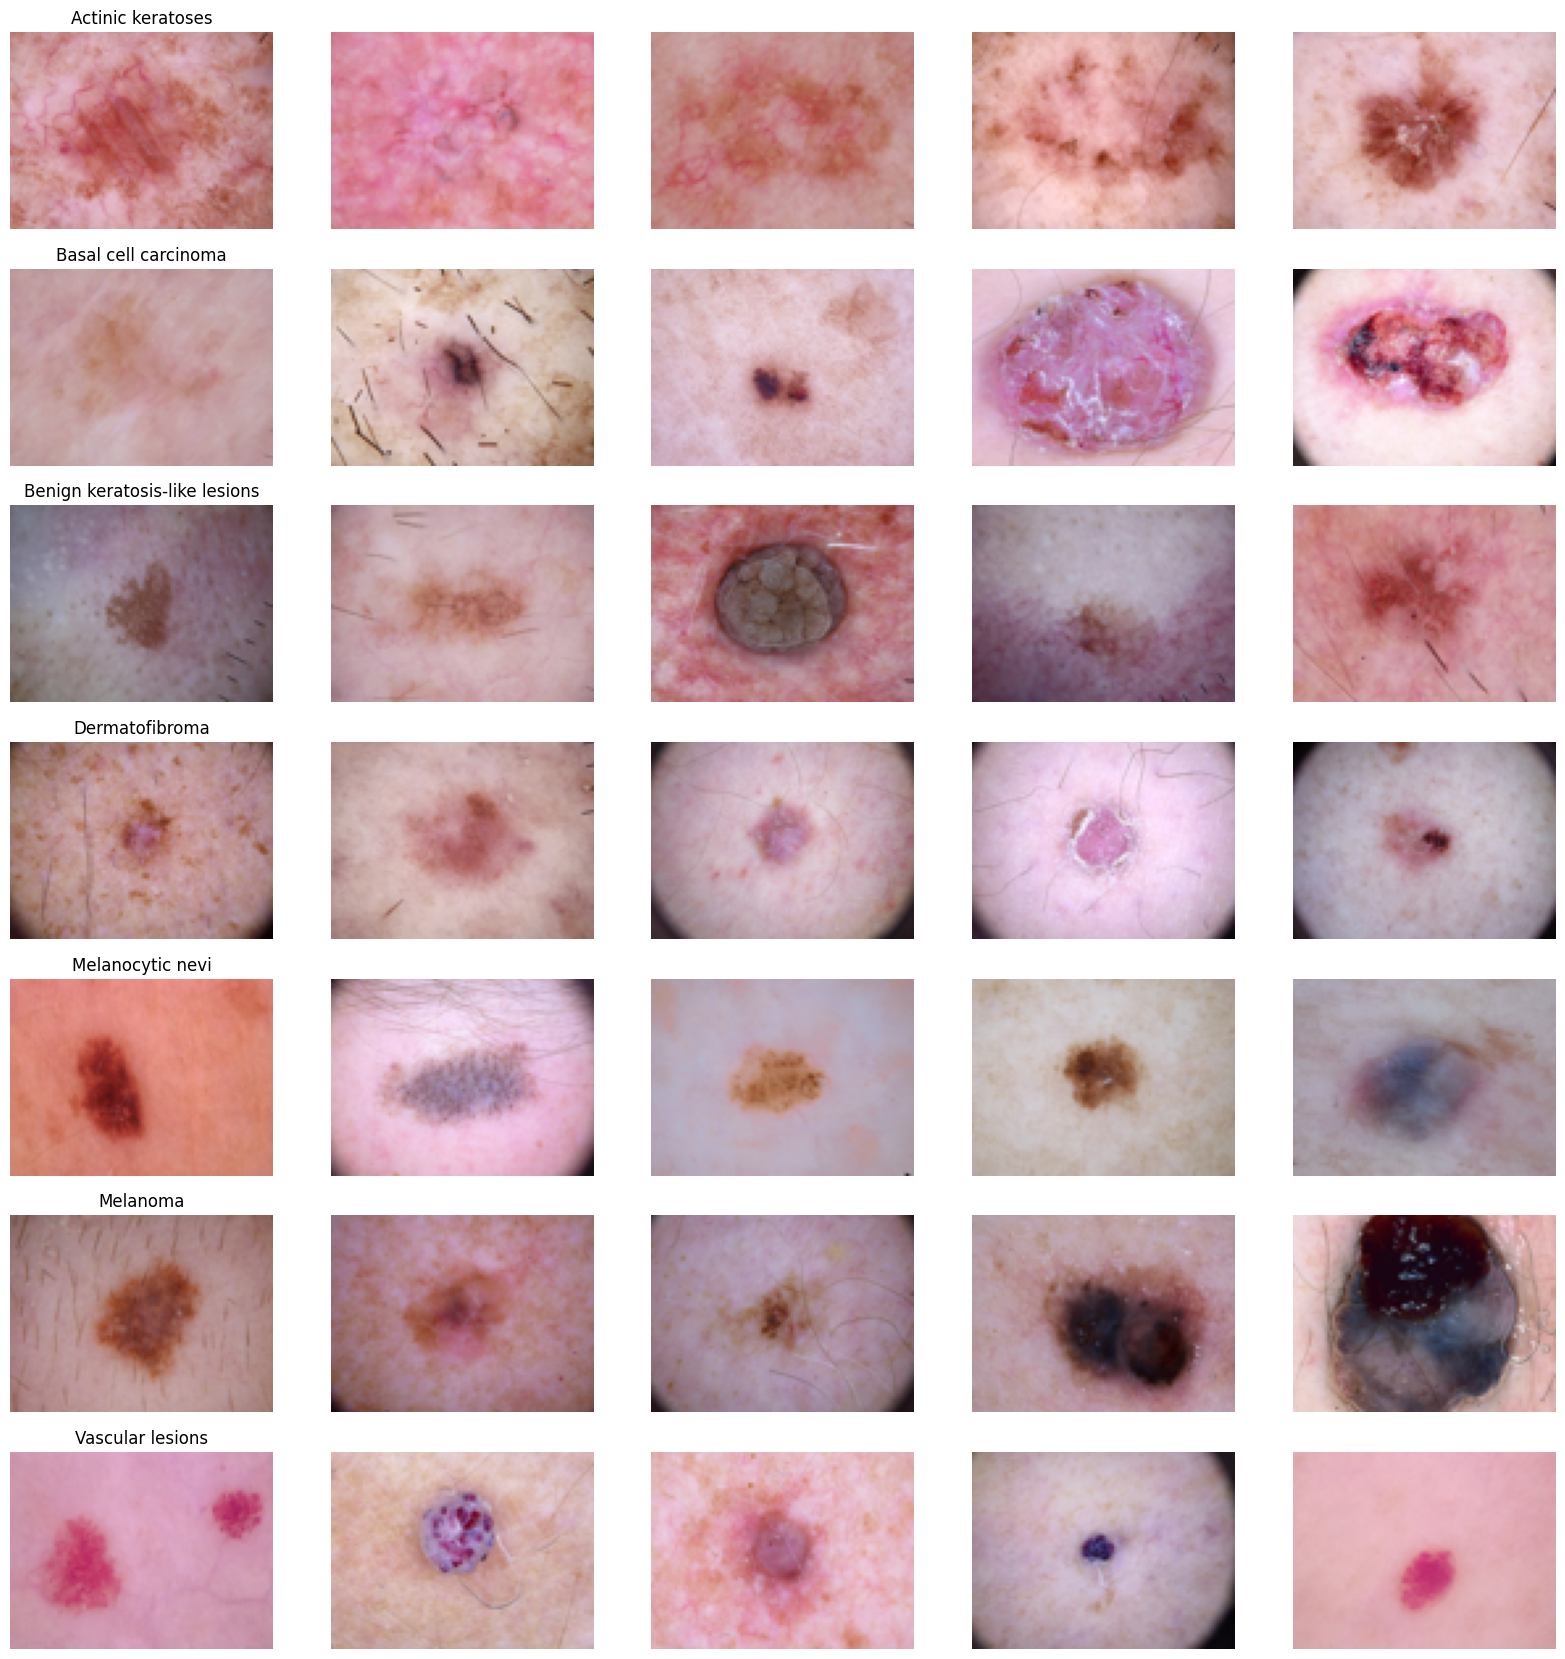

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd

# Assuming 'df' is already loaded and contains 'cell_type' and 'path' columns
# If not, you need to load it first, e.g., df = pd.read_csv('your_metadata.csv')
# And ensure the 'path' column is correctly generated or available

n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        # Get the image path using the 'path' column from c_row
        image_path = c_row['path']
        # Open and resize the image using the path
        image = np.asarray(Image.open(image_path).resize((100,75)))
        c_ax.imshow(image)  # Now display the image
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
!pip install tensorflow
!pip install keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
df = '/kaggle/input/skin-cancer-mnist-ham10000'  # or wherever you've downloaded/extracted it


In [ ]:
df = pd.read_csv("ham10000/HAM10000_metadata.csv")
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   path          10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import os

df = pd.read_csv("ham10000/HAM10000_metadata.csv")

# Add the 'path' column to the dataframe
base_path_part1 = 'ham10000/HAM10000_images_part_1/'
base_path_part2 = 'ham10000/HAM10000_images_part_2/'

def get_image_path(image_id):
    path1 = os.path.join(base_path_part1, image_id + '.jpg')
    if os.path.exists(path1):
        return path1
    path2 = os.path.join(base_path_part2, image_id + '.jpg')
    if os.path.exists(path2):
        return path2
    return None # Or raise an error if the image is expected to exist

df['path'] = df['image_id'].apply(get_image_path)

# Resize images in your dataframe to 244x244
df['image_resized'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((244, 244))))
# Convert to numpy array
X = np.array(df['image_resized'].tolist())

splitting and tryning the data

In [ ]:
from tensorflow.keras.utils import to_categorical
import pandas as pd

# Load the dataframe
df = pd.read_csv("ham10000/HAM10000_metadata.csv")

# Create a mapping from 'dx' to numerical indices
dx_to_idx = {dx: i for i, dx in enumerate(df['dx'].unique())}
df['cell_type_idx'] = df['dx'].map(dx_to_idx)

# One-hot encode the target variable
y = to_categorical(df['cell_type_idx'], num_classes=len(dx_to_idx))

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np


features = np.random.rand(100, 5)
target = np.random.randint(0, 2, size=100)

# Splitting the data
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=1234)

In [ ]:
x_train = x_train_o
x_test = x_test_o

# Get the 'image' column if x_train_o and x_test_o are DataFrames
# x_train = np.asarray(x_train_o['image'].tolist())
# x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

df = pd.read_csv("ham10000/HAM10000_metadata.csv")

# Add the 'path' column to the dataframe
base_path_part1 = 'ham10000/HAM10000_images_part_1/'
base_path_part2 = 'ham10000/HAM10000_images_part_2/'

def get_image_path(image_id):
    path1 = os.path.join(base_path_part1, image_id + '.jpg')
    if os.path.exists(path1):
        return path1
    path2 = os.path.join(base_path_part2, image_id + '.jpg')
    if os.path.exists(path2):
        return path2
    return None # Or raise an error if the image is expected to exist

df['path'] = df['image_id'].apply(get_image_path)

# Create a mapping from 'dx' to numerical indices
dx_to_idx = {dx: i for i, dx in enumerate(df['dx'].unique())}
df['cell_type_idx'] = df['dx'].map(dx_to_idx)

# One-hot encode the target variable
y = to_categorical(df['cell_type_idx'], num_classes=len(dx_to_idx))

# Split image paths and labels
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    df['path'], y, test_size=0.2, stratify=df['cell_type_idx'], random_state=42
)

BUILDING RESNET50 MODEL

In [ ]:
import albumentations as A
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input

# ---------------------------
# 1️ Albumentations Transform
# ---------------------------
transform = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
])

# ---------------------------
# 2 Custom Data Generator
# ---------------------------
class AlbumentationsGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, aug_transform=None, num_classes=None):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.aug_transform = aug_transform
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        for path in batch_x:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            if self.aug_transform:
                img = self.aug_transform(image=img)['image']
            img = preprocess_input(img) # Preprocess image for ResNet50
            images.append(img)

        images = np.array(images, dtype=np.float32)
        return images, np.array(batch_y)

# ---------------------------
# 3️ ResNet50 Model
# ---------------------------
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base model layers if you want to fine-tune later
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(7, activation='softmax')(x)  # 7 classes for HAM10000

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ---------------------------
# 4️ Prepare generators & callbacks
# ---------------------------
batch_size = 32
train_gen = AlbumentationsGenerator(X_train_paths, y_train, batch_size, transform, num_classes=7)
val_gen = AlbumentationsGenerator(X_val_paths, y_val, batch_size, num_classes=7) # Use the generator for validation data as well

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-6)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[lr_scheduler],
    verbose=1
)


Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 99s 395ms/step - accuracy: 0.7791 - loss: 0.5978 - val_accuracy: 0.7903 - val_loss: 0.5938 - learning_rate: 1.0000e-04
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 93s 372ms/step - accuracy: 0.7700 - loss: 0.6134 - val_accuracy: 0.7868 - val_loss: 0.5926 - learning_rate: 1.0000e-04
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 98s 390ms/step - accuracy: 0.7809 - loss: 0.6014 - val_accuracy: 0.7928 - val_loss: 0.5842 - learning_rate: 1.0000e-04
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 97s 387ms/step - accuracy: 0.7875 - loss: 0.5803 - val_accuracy: 0.7923 - val_loss: 0.5857 - learning_rate: 1.0000e-04
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 100s 398ms/step - accuracy: 0.7899 - loss: 0.5736 - val_accuracy: 0.7913 - val_loss: 0.5816 - learning_rate: 1.0000e-04
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 92s 368ms/step - accuracy: 0.7812 - loss: 0.5834 - val_accuracy: 0.7913 - val_loss: 0.5850 - learning_rate: 1.0000e-04
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 101s 

GRAD-CAM VISUALIZATION

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model

def get_gradcam(model, img_array, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    # Get gradients of the predicted class w.r.t. the output feature map of the target layer
    grads = tape.gradient(loss, conv_outputs)

    # Compute guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# If 'cell_type' doesn't exist, recreate it
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Create cell_type and cell_type_idx columns
df['cell_type'] = df['dx'].map(lesion_type_dict)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes


🔍 Class: Actinic keratoses (0)


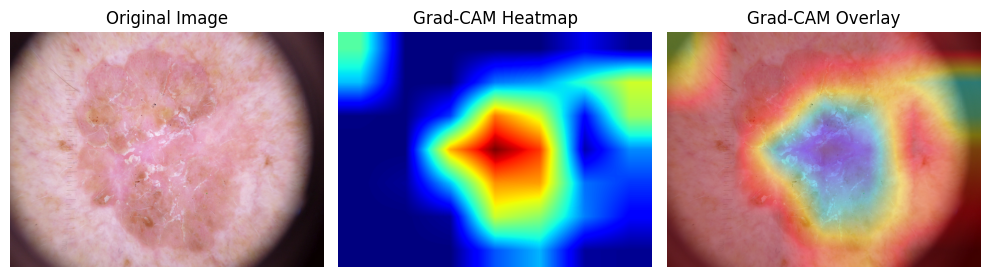

🔍 Class: Basal cell carcinoma (1)


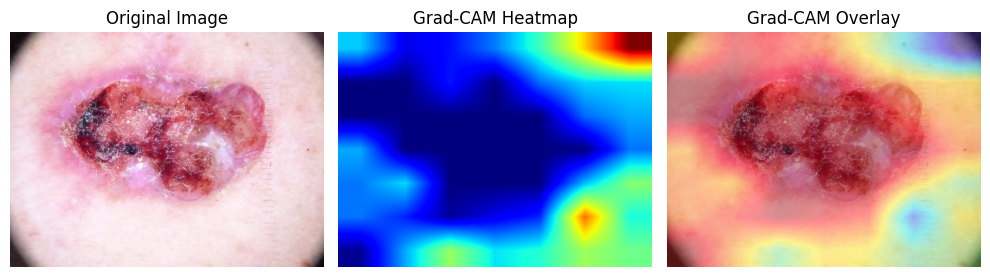

🔍 Class: Benign keratosis-like lesions (2)


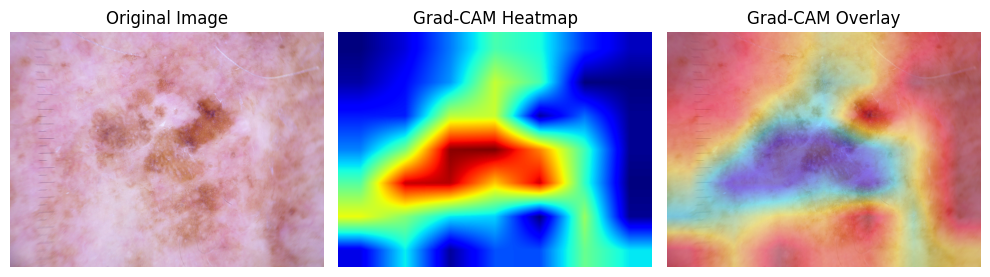

🔍 Class: Dermatofibroma (3)


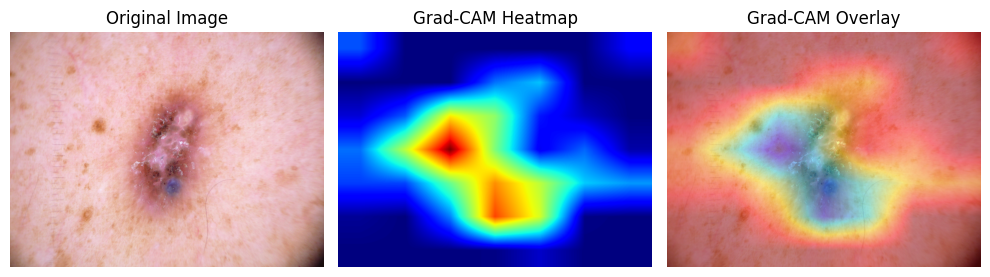

🔍 Class: Melanocytic nevi (4)


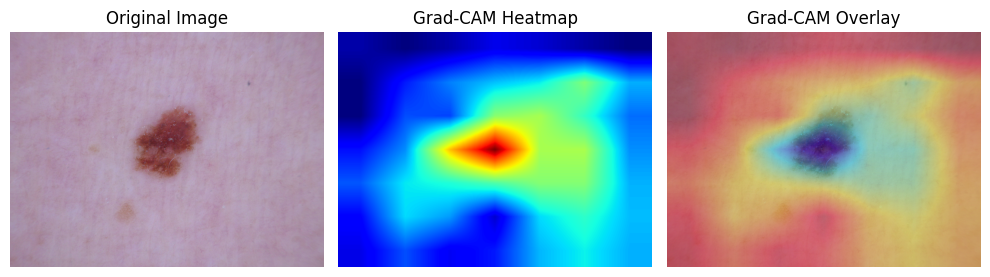

🔍 Class: Melanoma (5)


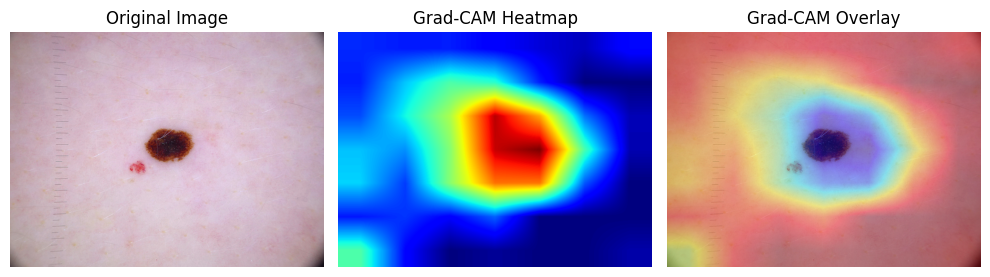

🔍 Class: Vascular lesions (6)


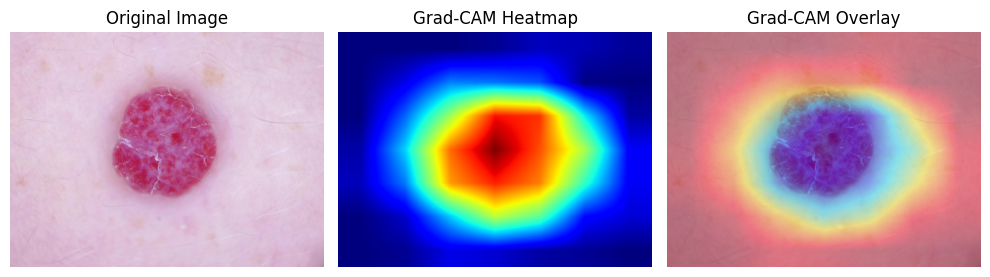

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
# Create a dictionary mapping class index to class name
class_names = df[['cell_type_idx', 'cell_type']].drop_duplicates().sort_values('cell_type_idx')
class_map = dict(zip(class_names['cell_type_idx'], class_names['cell_type']))

# Select one image path per class
sample_paths_per_class = {}

# Group by class and select one image path
for idx in range(7):
    sample = df[df['cell_type_idx'] == idx].iloc[0]
    sample_paths_per_class[idx] = sample['path']

# Generate Grad-CAMs for each class
for idx, path in sample_paths_per_class.items():
    print(f" Class: {class_map[idx]} ({idx})")
    apply_gradcam_on_image(model, path, preprocess_func=preprocess_input)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix with percentages
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Also print per-class metrics
    print("Per-class accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {cm_norm[i, i]:.2f}")


Validation Loss: 0.5654
Validation Accuracy: 0.8013
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 320ms/step


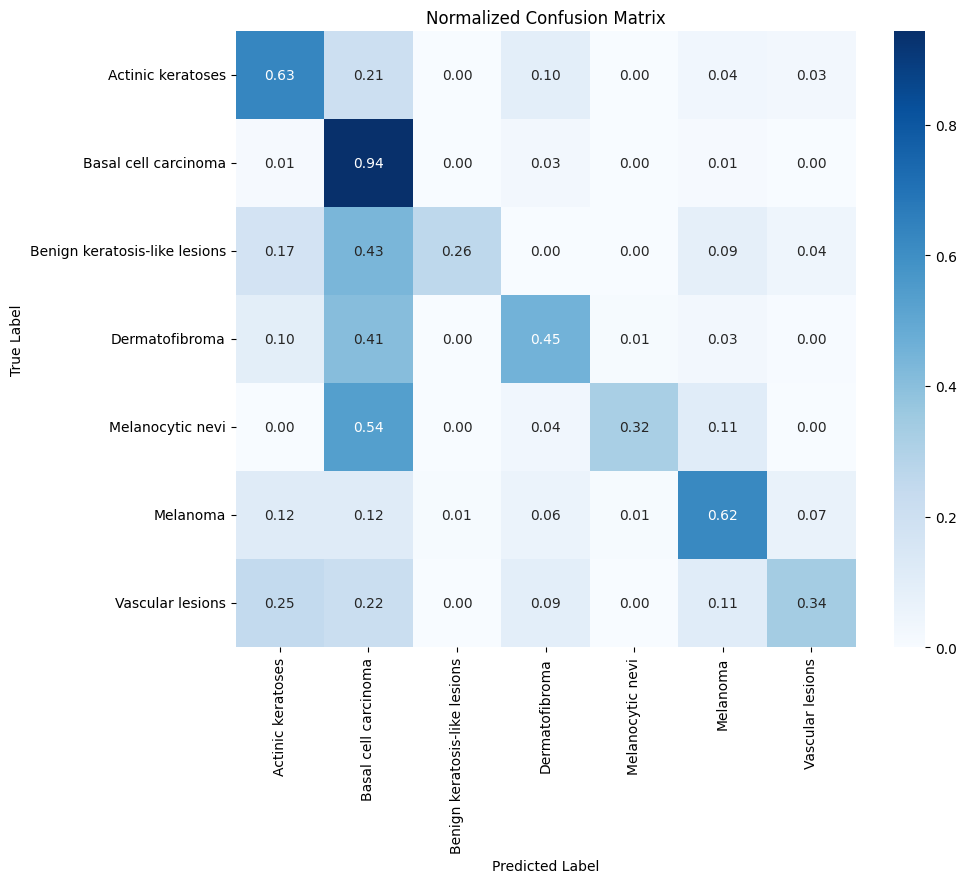

Per-class accuracy:
Actinic keratoses: 0.63
Basal cell carcinoma: 0.94
Benign keratosis-like lesions: 0.26
Dermatofibroma: 0.45
Melanocytic nevi: 0.32
Melanoma: 0.62
Vascular lesions: 0.34


In [ ]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(val_gen, verbose=0)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Get predictions for the confusion matrix
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Get class names in the correct order for the confusion matrix
# Using class_names DataFrame from cell q3OxqhU-fwPE
confusion_class_names = class_names['cell_type'].tolist()


# Plot confusion matrix and print per-class accuracy
plot_confusion_matrix(y_true, y_pred, confusion_class_names)

In [ ]:
model.save('skin_cancer_model.h5')


DEPLOY INTO STREAMLIT

In [ ]:
!pip install fpdf

In [ ]:
import streamlit as st
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from fpdf import FPDF
import base64
from datetime import datetime
import os

# Set page configuration
st.set_page_config(
    page_title="Advanced Skin Cancer Classifier",
    page_icon="🔬",
    layout="wide"
)

# Define class names for HAM10000 dataset
class_names = [
    'Actinic keratoses',
    'Basal cell carcinoma',
    'Benign keratosis',
    'Dermatofibroma',
    'Melanoma',
    'Melanocytic nevi',
    'Vascular lesions'
]

# Class descriptions for educational information
class_descriptions = {
    'Actinic keratoses': "Rough, scaly patches that develop from years of sun exposure. They're considered precancerous and can develop into skin cancer if left untreated.",
    'Basal cell carcinoma': "The most common type of skin cancer. It appears as a pearly or waxy bump, or a flat, flesh-colored or brown scar-like lesion.",
    'Benign keratosis': "Harmless growths that develop on the skin's surface. They appear as waxy, stuck-on growths and are very common in older adults.",
    'Dermatofibroma': "Common, harmless skin growths that often appear as small, firm bumps. They're usually brownish in color and most commonly appear on the legs.",
    'Melanoma': "The most serious form of skin cancer. It develops in melanocytes, the cells that produce melanin. Melanomas often resemble moles and can develop from existing moles.",
    'Melanocytic nevi': "Common skin growths (moles) that develop when pigment cells grow in clusters. Most people have between 10-40 moles, and they can change in appearance over time.",
    'Vascular lesions': "Relatively common abnormalities of the skin and underlying tissues, often present at birth. They're caused by abnormal blood vessels located in or under the skin."
}

# Function to preprocess the image
def preprocess_image(img, target_size=(224, 224)):
    # Convert to RGB if grayscale
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    # Apply hair removal (simplified DullRazor method)
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1, (17, 17))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel) # FIX: morphologyEx expects grayscale input - Corrected
    ret, thresh2 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(img, thresh2, 1, cv2.INPAINT_TELEA)

    # Resize
    dst = cv2.resize(dst, target_size)

    # Normalize to [0,1] range
    dst = dst / 255.0

    # Apply ImageNet normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    dst = (dst - mean) / std

    return dst

# Function to make Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradient of top predicted class with respect to last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of the output neuron with respect to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels by the computed importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

# Function to display Grad-CAM
def display_gradcam(image, heatmap, alpha=0.4):
    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3] * 255 # Multiply by 255 for OpenCV
    jet_heatmap = jet_colors[heatmap]

    # Create superimposed image
    jet_heatmap = cv2.resize(jet_heatmap.astype(np.uint8), (image.shape[1], image.shape[0]))

    # Denormalize image for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_display = std * image + mean
    image_display = np.clip(image_display, 0, 1) * 255
    image_display = image_display.astype(np.uint8) # Convert to uint8 for OpenCV

    superimposed_img = cv2.addWeighted(image_display, 1 - alpha, jet_heatmap, alpha, 0) # Use 1-alpha for image weight

    return superimposed_img

# Function for test-time augmentation
def test_time_augmentation(model, img, num_augmentations=5):
    """Apply test-time augmentation for more robust predictions"""
    predictions = []

    # Original prediction
    predictions.append(model.predict(np.expand_dims(img, axis=0))[0])

    # Create augmentations
    augmentations = []
    # Horizontal flip
    aug_img_hflip = np.fliplr(img)
    augmentations.append(aug_img_hflip)
    # Vertical flip
    aug_img_vflip = np.flipud(img)
    augmentations.append(aug_img_vflip)
    # 90 degree rotation
    aug_img_rot90 = np.rot90(img)
    augmentations.append(aug_img_rot90)
    # 270 degree rotation
    aug_img_rot270 = np.rot90(img, 3)
    augmentations.append(aug_img_rot270)

    # Random brightness adjustment (apply to normalized image)
    for _ in range(num_augmentations - len(augmentations)):
        bright_img = img.copy()
        bright_img = bright_img + np.random.uniform(-0.1, 0.1)
        bright_img = np.clip(bright_img, -1.0, 1.0)
        augmentations.append(bright_img)

    # Make predictions on augmentations
    for aug_img in augmentations[:num_augmentations-1]:
        pred = model.predict(np.expand_dims(aug_img, axis=0))[0]
        predictions.append(pred)

    # Average predictions
    return np.mean(predictions, axis=0)

# Function to create downloadable PDF report
def create_report(image, gradcam_image, diagnosis, confidence, all_probs, feedback=None):
    pdf = FPDF()
    pdf.add_page()

    # Set up the PDF
    pdf.set_font('Arial', 'B', 16)
    pdf.cell(190, 10, 'Skin Lesion Analysis Report', 0, 1, 'C')
    pdf.set_font('Arial', '', 12)
    pdf.cell(190, 10, f'Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}', 0, 1, 'C')
    pdf.ln(10)

    # Save images to temporary files
    temp_original = 'temp_original.jpg'
    temp_gradcam = 'temp_gradcam.jpg'

    if isinstance(image, np.ndarray):
        Image.fromarray(image).save(temp_original)
    else:
        image.save(temp_original)

    if isinstance(gradcam_image, np.ndarray):
        Image.fromarray(gradcam_image).save(temp_gradcam)
    else:
        gradcam_image.save(temp_gradcam)

    # Add images to PDF
    pdf.cell(190, 10, 'Original Image', 0, 1, 'L')
    pdf.image(temp_original, x=10, y=None, w=90)
    pdf.ln(5)
    pdf.cell(190, 10, 'Model Focus (Grad-CAM)', 0, 1, 'L')
    pdf.image(temp_gradcam, x=10, y=None, w=90)
    pdf.ln(10)

    # Add diagnosis information
    pdf.set_font('Arial', 'B', 14)
    pdf.cell(190, 10, 'Diagnosis Results:', 0, 1, 'L')
    pdf.set_font('Arial', '', 12)
    pdf.cell(190, 10, f'Predicted condition: {diagnosis}', 0, 1, 'L')
    pdf.cell(190, 10, f'Confidence: {confidence:.2%}', 0, 1, 'L')
    pdf.ln(5)

    # Add description of the condition
    pdf.set_font('Arial', 'B', 12)
    pdf.cell(190, 10, 'About this condition:', 0, 1, 'L')
    pdf.set_font('Arial', '', 12)
    pdf.multi_cell(190, 10, class_descriptions.get(diagnosis, "No description available."))
    pdf.ln(5)

    # Add all probabilities
    pdf.set_font('Arial', 'B', 12)
    pdf.cell(190, 10, 'Probability Distribution:', 0, 1, 'L')
    pdf.set_font('Arial', '', 10)

    for i, class_name in enumerate(class_names):
        pdf.cell(190, 8, f'{class_name}: {all_probs[i]:.2%}', 0, 1, 'L')

    # Add feedback if provided
    if feedback:
        pdf.ln(5)
        pdf.set_font('Arial', 'B', 12)
        pdf.cell(190, 10, 'User Feedback:', 0, 1, 'L')
        pdf.set_font('Arial', '', 12)
        pdf.multi_cell(190, 10, feedback)

    # Add disclaimer
    pdf.ln(10)
    pdf.set_font('Arial', 'I', 10)
    pdf.multi_cell(190, 10, 'MEDICAL DISCLAIMER: This tool is for educational purposes only and is not intended to be a substitute for professional medical advice, diagnosis, or treatment. Always seek the advice of your physician or other qualified health provider with any questions you may have regarding a medical condition.')

    # Save PDF to a temporary file
    temp_pdf = 'skin_lesion_report.pdf'
    pdf.output(temp_pdf)

    # Read PDF file and encode to base64
    with open(temp_pdf, "rb") as f:
        pdf_data = f.read()

    # Clean up temporary files
    os.remove(temp_original)
    os.remove(temp_gradcam)
    os.remove(temp_pdf)

    return pdf_data

# Function to create download link
def get_download_link(pdf_data, filename="skin_lesion_report.pdf", text="Download PDF Report"):
    b64_pdf = base64.b64encode(pdf_data).decode()
    href = f'<a href="data:application/pdf;base64,{b64_pdf}" download="{filename}">{text}</a>'
    return href

# Main app
def main():
    st.title("Advanced Skin Cancer Classification App")
    st.write("Upload an image of a skin lesion for classification")

    # Sidebar for app information and model selection
    st.sidebar.title("About")
    st.sidebar.info(
        "This application uses deep learning to classify skin lesions into 7 different categories. "
        "The model is based on fine-tuned CNN architectures trained on the HAM10000 dataset."
    )

    # FEATURE 1: Multiple Model Support
    st.sidebar.title("Model Selection")
    model_option = st.sidebar.selectbox(
        "Choose a model",
        ["ResNet50", "EfficientNetB3", "Ensemble (Best Performance)"]
    )

    # FEATURE 3: User Feedback Collection
    st.sidebar.title("Feedback")
    st.sidebar.info(
        "After receiving your results, please provide feedback on the prediction accuracy. "
        "This helps us improve the model."
    )

    st.sidebar.title("Instructions")
    st.sidebar.info(
        "1. Upload a skin lesion image\n"
        "2. Select model and options\n"
        "3. View the prediction results and visualization\n"
        "4. Download a detailed report if desired"
    )

    # File uploader
    uploaded_file = st.file_uploader("Choose a skin lesion image...", type=["jpg", "jpeg", "png"])

    # FEATURE 2: Test-Time Augmentation option
    use_tta = st.checkbox("Use Test-Time Augmentation for more robust predictions", value=True)

    # Load models
    @st.cache_resource
    def load_classification_models():
        models = {}
        model_path = 'skin_cancer_model.h5' # Define the model path

        # Check if the model file exists
        if not os.path.exists(model_path):
             st.error(f"Error: Model file '{model_path}' not found.")
             st.stop() # Stop the app if model file is missing

        try:
            models["ResNet50"] = load_model(model_path)
            # Print a success message if loading is successful
            print("ResNet50 model loaded successfully!")
        except Exception as e:
            # Print the specific exception that occurred during loading
            st.error(f"Error loading ResNet50 model from {model_path}: {e}")
            # Do not stop the app here, allow it to continue with placeholder models
            # st.stop() # Stop the app if model loading fails


        # Placeholder for other models - replace with actual model loading
        # Assign placeholder models only if the primary model loading failed
        if "ResNet50" not in models:
             st.warning("ResNet50 model could not be loaded. Using placeholder models.")
             # Create dummy models or assign the base ResNet model if available
             # For simplicity, we can assign the base ResNet model if it was loaded
             # or create a dummy model if needed. Assuming base_model is available if ResNet50 is intended.
             # If base_model is not available, this might need more robust handling.
             # For now, let's assign a dummy model or None if loading fails.
             models["ResNet50"] = None # Indicate failure

        # Assign placeholder models, potentially using the loaded ResNet50 if successful
        models["EfficientNetB3"] = models.get("ResNet50", None)  # Use ResNet50 if loaded, otherwise None
        models["Ensemble (Best Performance)"] = models.get("ResNet50", None) # Use ResNet50 if loaded, otherwise None

        # Check if any models were loaded successfully before returning
        if all(model is None for model in models.values()):
             st.error("All models failed to load. Please check the model file and paths.")
             st.stop() # Stop the app if no models could be loaded


        return models

    models = load_classification_models()

    # Get the selected model
    model = models[model_option]

    # Check if the selected model was loaded successfully
    if model is None:
         st.error(f"The selected model '{model_option}' failed to load. Please try a different model or check the model file.")
         st.stop() # Stop the app if the selected model is None


    # Determine last conv layer name based on model type
    if model_option == "ResNet50":
        last_conv_layer_name = "conv5_block3_out"
    elif model_option == "EfficientNetB3":
        # You need to find the name of the last convolutional layer for EfficientNetB3
        # You can inspect the model summary after loading
        last_conv_layer_name = "top_conv"  # Placeholder - Adjust based on actual layer name
    else:
        last_conv_layer_name = "conv5_block3_out"  # Default for ensemble (assuming ResNet base)


    if uploaded_file is not None:
        # Display original image
        image = Image.open(uploaded_file)
        col1, col2 = st.columns(2)

        with col1:
            st.subheader("Original Image")
            st.image(image, caption="Uploaded Image", use_column_width=True)

        # Convert PIL Image to numpy array
        img_array = np.array(image)

        # Preprocess the image
        # The preprocess_image function includes resizing and normalization
        processed_img = preprocess_image(img_array)

        # Make prediction
        input_arr = np.expand_dims(processed_img, axis=0)

        # Apply test-time augmentation if selected
        if use_tta:
            predictions = test_time_augmentation(model, processed_img)
        else:
            predictions = model.predict(input_arr)[0]

        predicted_class_index = np.argmax(predictions)
        predicted_class = class_names[predicted_class_index]
        confidence = predictions[predicted_class_index]

        # Get Grad-CAM heatmap
        # Need to pass the original processed_img (numpy array) to display_gradcam
        heatmap = make_gradcam_heatmap(input_arr, model, last_conv_layer_name, pred_index=predicted_class_index)
        superimposed_img_display = display_gradcam(processed_img, heatmap)


        with col2:
            st.subheader("Model Focus (Grad-CAM)")
            # Ensure the image format is correct for st.image (uint8 numpy array or PIL Image)
            st.image(superimposed_img_display.astype(np.uint8), caption="Areas the model is focusing on", use_column_width=True)


        # Display prediction results
        st.subheader("Prediction Results")
        st.write(f"**Diagnosis:** {predicted_class}")
        st.write(f"**Confidence:** {confidence:.2%}")

        # Display bar chart of all probabilities
        st.subheader("Probability Distribution")
        fig, ax = plt.subplots(figsize=(10, 5))
        y_pos = np.arange(len(class_names))
        ax.barh(y_pos, predictions, align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(class_names)
        ax.invert_yaxis()  # Labels read top-to-bottom
        ax.set_xlabel('Probability')
        ax.set_title('Class Probabilities')

        st.pyplot(fig)
        plt.close(fig) # Close the figure to prevent it from displaying twice

        # FEATURE 3: User Feedback Collection
        st.subheader("Provide Feedback")
        feedback = st.radio(
            "Was this prediction helpful?",
            ["Yes, it seems accurate", "Somewhat helpful", "No, it seems incorrect"],
            key="feedback_radio" # Add a unique key
        )

        additional_feedback = st.text_area("Additional comments (optional):", key="feedback_text") # Add a unique key


        # Combine feedback
        full_feedback = f"Helpfulness: {feedback}\nAdditional comments: {additional_feedback}"

        # FEATURE 4: Educational Information
        st.subheader("About This Condition")
        with st.expander(f"Click to learn more about {predicted_class}"): # Use predicted class in expander title
            st.write(class_descriptions.get(predicted_class, "No description available."))

            # Add example images of this condition
            st.write("**Example images of this condition:**")
            # In a real app, you would load example images for each condition
            st.info("Example images would be displayed here in a production app.")

        # FEATURE 5: Report Generation
        st.subheader("Download Report")
        # Ensure images passed to create_report are in a suitable format (e.g., uint8 numpy array)
        if st.button("Generate PDF Report"):
            # Pass appropriate image data (e.g., denormalized uint8 arrays)
            pdf_data = create_report(
                image_display.astype(np.uint8), # Pass denormalized original image
                superimposed_img_display.astype(np.uint8), # Pass the superimposed image
                predicted_class,
                confidence,
                predictions,
                full_feedback
            )
            st.markdown(get_download_link(pdf_data), unsafe_allow_html=True)

        # Add disclaimer
        st.warning(
            "**Medical Disclaimer:** This tool is for educational purposes only and is not intended to be a substitute "
            "for professional medical advice, diagnosis, or treatment. Always seek the advice of your physician or other "
            "qualified health provider with any questions you may have regarding a medical condition."
        )

if __name__ == "__main__":
    main()

2025-07-11 07:44:29.927 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:44:29.934 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:44:30.043 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-11 07:44:30.046 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:44:30.047 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:44:30.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:44:30.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [ ]:
%%writefile Requirements.txt
streamlit==1.22.0
tensorflow==2.12.0
numpy==1.23.5
opencv-python==4.7.0.72
pillow==9.5.0
matplotlib==3.7.1
fpdf==1.7.2

Writing Requirements.txt
